In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Suppress Warnings
warnings.filterwarnings("ignore")

In [3]:
# Load dataset 
df = pd.read_csv("kc_house_data.csv")

In [4]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')

In [5]:
# Remove anomalies (houses with 0 bedrooms & bathrooms)
df = df[~((df['bedrooms'] == 0) & (df['bathrooms'] == 0))]
df = df[df['bedrooms'] <= 10]  # Remove extreme outliers

In [6]:
# Select relevant features for modeling
features = ['sqft_living', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 
            'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 
            'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long']
target = 'price'

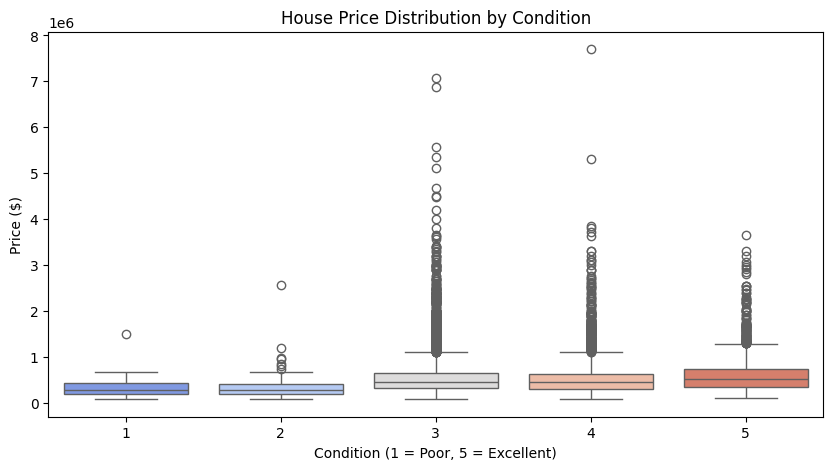

In [7]:
# 1. Box Plot: Price by Condition
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['condition'], y=df['price'], palette="coolwarm")
plt.xlabel("Condition (1 = Poor, 5 = Excellent)")
plt.ylabel("Price ($)")
plt.title("House Price Distribution by Condition")
plt.show()

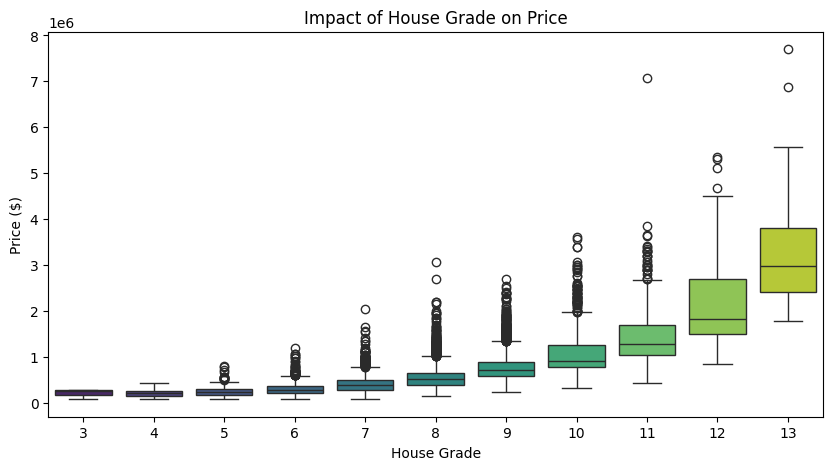

In [8]:
# 2. Box Plot: Price by House Grade
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['grade'], y=df['price'], palette="viridis")
plt.xlabel("House Grade")
plt.ylabel("Price ($)")
plt.title("Impact of House Grade on Price")
plt.show()

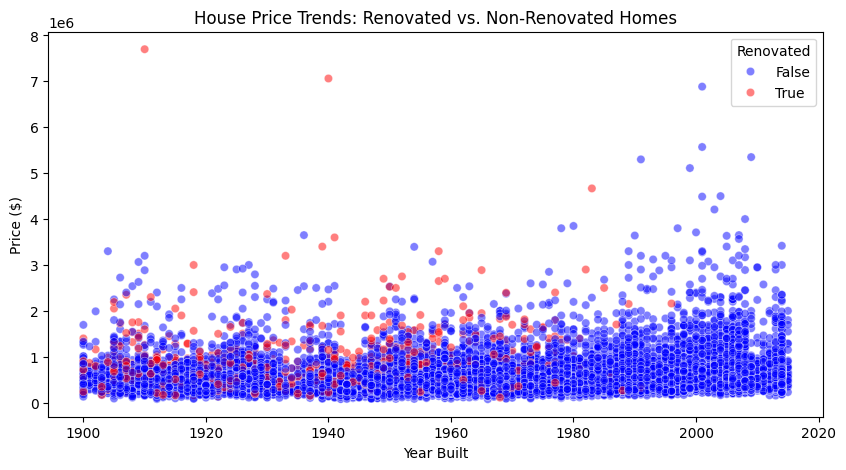

In [9]:
# 3. Scatter Plot: Price vs. Year Built (Highlighting Renovated Homes)
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['yr_built'], y=df['price'], hue=df['yr_renovated'] > 0, palette={True: "red", False: "blue"}, alpha=0.5)
plt.xlabel("Year Built")
plt.ylabel("Price ($)")
plt.title("House Price Trends: Renovated vs. Non-Renovated Homes")
plt.legend(title="Renovated")
plt.show()

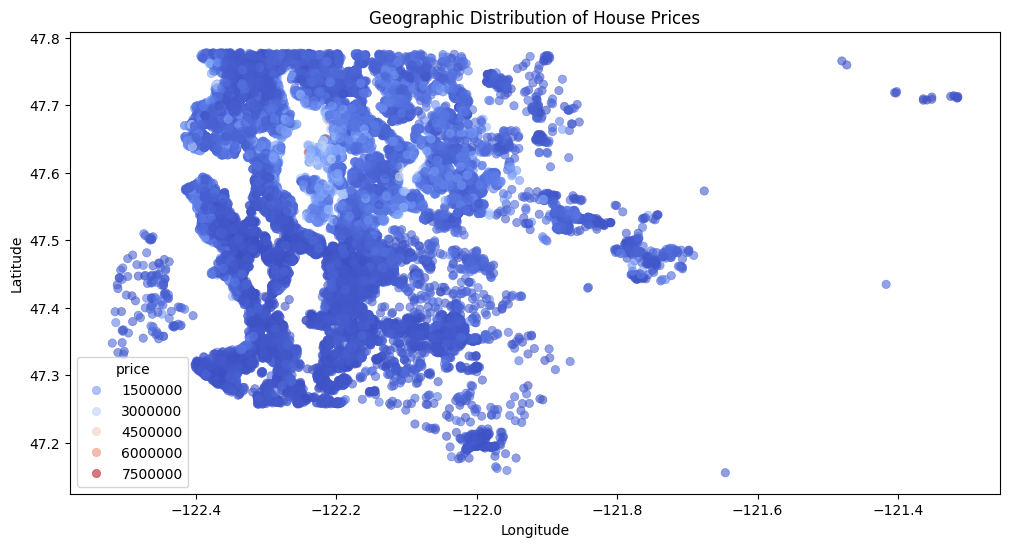

In [10]:
# 4. Geographic Heatmap: Price by Location (Latitude & Longitude)
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['long'], y=df['lat'], hue=df['price'], palette="coolwarm", alpha=0.6, edgecolor=None)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of House Prices")
plt.show()

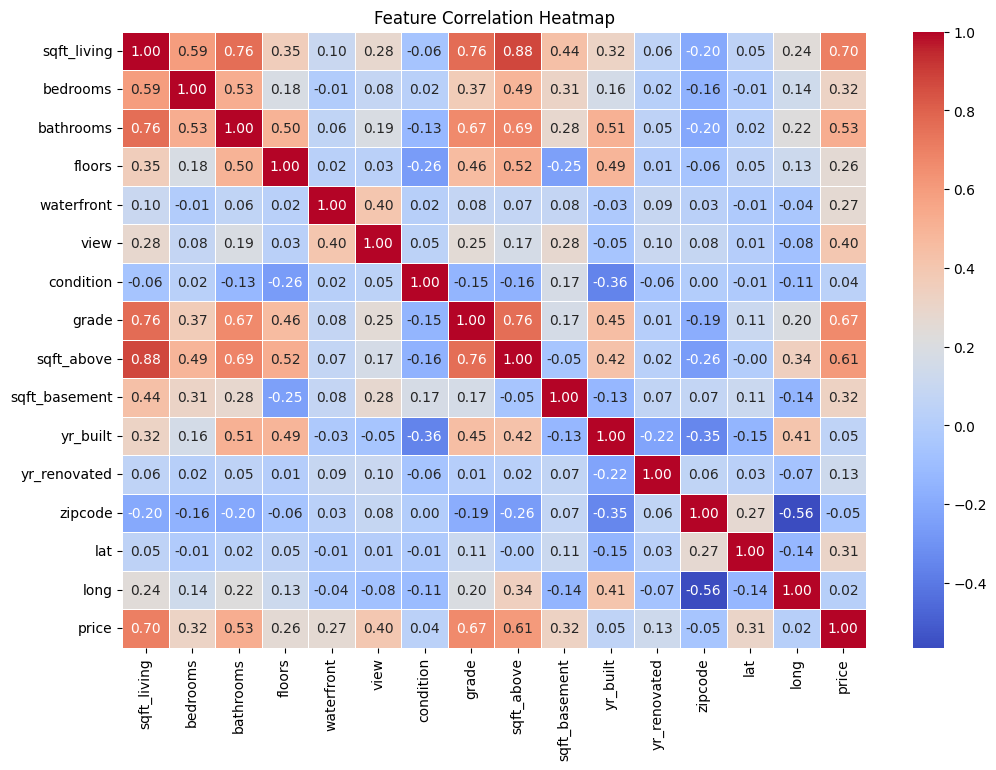

In [ ]:
# 5. Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[features + [target]].corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

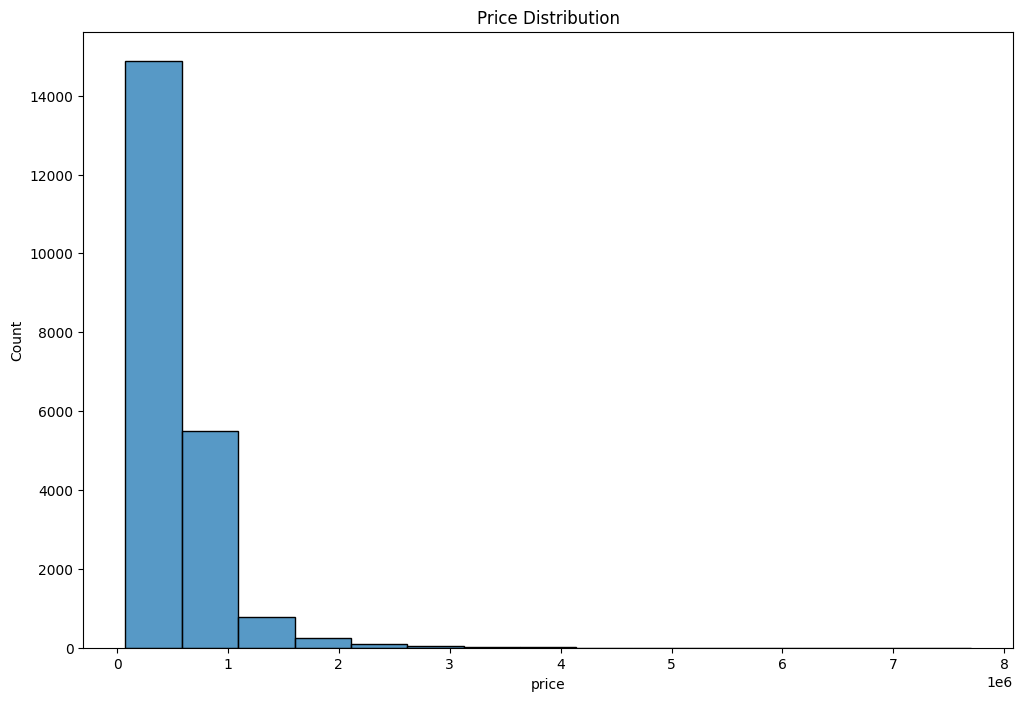

In [23]:
# 6. Histogram for Price
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x="price", bins=15)
plt.title("Price Distribution")
plt.show()

In [12]:
# Split data into train and test sets
X = df[features]
y = df[target]

In [13]:
# Convert categorical variables (zipcode) using one-hot encoding
X = pd.get_dummies(X, columns=['zipcode'], drop_first=True)

In [14]:
# Train-test split (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# For AIC calculations - 
n = y_test.shape[0]
k = X_train.shape[1]

In [15]:
# Model 1: Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

In [16]:
# Evaluate Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
aic_lr = n * np.log(rmse_lr) + 2 * k

In [17]:
# Model 2: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [18]:
# Evaluate Random Forest
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
aic_rf = n * np.log(rmse_rf) + 2 * k

In [19]:
# Model Comparison
models = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "R² Score": [r2_lr, r2_rf],
    "RMSE": [rmse_lr, rmse_rf],
    "MAE": [mae_lr, mae_rf],
    "AIC": [aic_lr, aic_rf]
})
print("\n Model Performance Comparison:")
print(models)


 Model Performance Comparison:
               Model  R² Score           RMSE           MAE           AIC
0  Linear Regression  0.806239  167018.486466  97998.108436  78117.623111
1      Random Forest  0.876061  133578.169279  73376.741856  76669.429842


In [25]:
# Feature Importance (Random Forest)
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)
print("Feature Importance: ")
print(feature_importances[:7])

Feature Importance: 
        Feature  Importance
7         grade    0.338750
0   sqft_living    0.249660
12          lat    0.165326
13         long    0.068166
4    waterfront    0.033107
10     yr_built    0.032127
8    sqft_above    0.027641


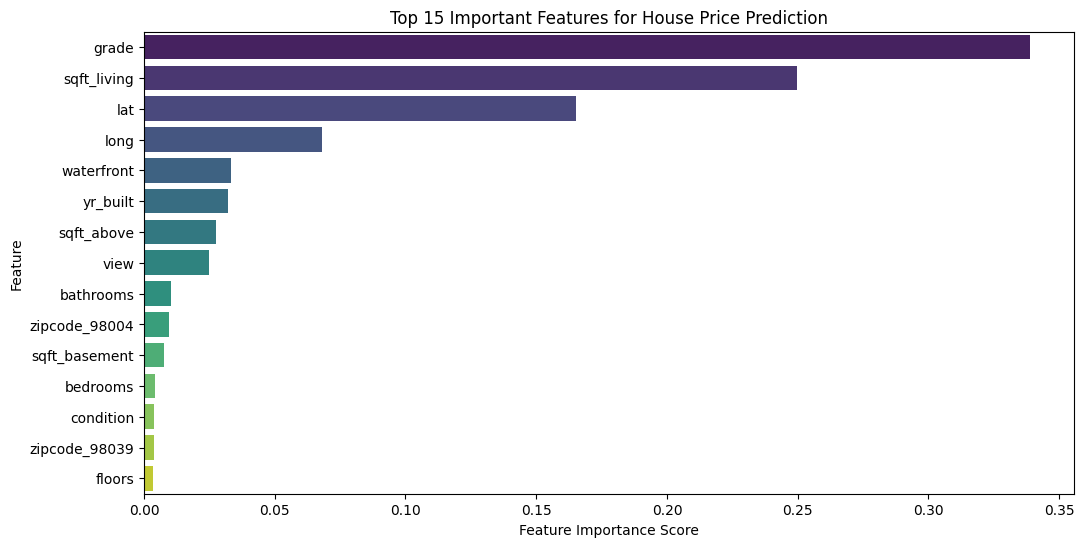

In [21]:
# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances[:15], palette="viridis")
plt.title("Top 15 Important Features for House Price Prediction")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.show()